In [1]:
from torch import nn
from torchsummary import summary
import torch 
# from U2Net_.model import U2NET
from scipy import ndimage
import PIL
import random

import os
import pydiffvg
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import warp
from skimage import transform as tf
import imageio 
import matplotlib.font_manager as font_manager
import skimage
import skimage.io
from torchvision import transforms
import os, sys
import PIL
p = os.path.abspath('..')
sys.path.insert(1, p)
import sketch_utils as utils
from U2Net_.model import U2NET
from scipy import ndimage
from torchvision.utils import make_grid

device = torch.device("cuda:0" if (
            torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")
# model, clip_preprocess = clip.load(
#             "ViT-B/32", device, jit=False)
# del model


In [2]:
from torchvision import models, transforms

target = Image.open("/home/vinker/dev/backgroundCLIPasso/CLIPasso/target_images/complex-scene-crop.png")
image_scale = 224
transforms_ = []

# if target.size[0] != target.size[1]:
transforms_.append(transforms.Resize(
    image_scale, interpolation=PIL.Image.BICUBIC))
transforms_.append(transforms.CenterCrop(image_scale))
    
# else:
#     transforms_.append(transforms.Resize(
#         (image_scale, image_scale), interpolation=PIL.Image.BICUBIC))
data_transforms = transforms.Compose(transforms_)
print(clip_preprocess)
plt.imshow(target)
plt.show()
clip_preprocess2 = transforms.Compose([clip_preprocess.transforms[0]])
print(clip_preprocess2)
im2 = data_transforms(target)
plt.imshow(im2)#.permute(1,2,0))
plt.show()

NameError: name 'clip_preprocess' is not defined

In [3]:

import collections
import clip
import torch
import torch.nn as nn
from torchvision import models, transforms


class CLIPmaskLoss(torch.nn.Module):
    def __init__(self, clip_conv_layer_weights, mask):
        super(CLIPmaskLoss, self).__init__()
        self.clip_conv_layer_weights = clip_conv_layer_weights
        self.clip_rn_layer_weights = [0,0,1.0,1.0,0]
        device = torch.device("cuda:3" if (
            torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")
        self.clip_model_name = "ViT-B/32"
        self.clip_for_model_name = "RN101"
        
        self.device = device
        self.num_augs = 4
        
        self.clip_conv_loss_type = "L2"
        self.clip_fc_loss_type = "Cos"  # args.clip_fc_loss_type
        
        self.mask = torch.cat([mask, mask, mask], axis=0).to(device)
        
        self.valid_models = [
            "RN50",
            "RN101",
            "RN50x4",
            "RN50x16",
            "ViT-B/32",
            "ViT-B/16",
        ]
        assert self.clip_model_name in self.valid_models and self.clip_for_model_name in self.valid_models
        self.distance_metrics = \
            {
                "L2": l2_layers,
                "L1": l1_layers,
                "Cos": cos_layers
            }
        
        # background model (ViT)
        self.model, clip_preprocess = clip.load(
            self.clip_model_name, device, jit=False)
        self.model.eval()
        if self.clip_model_name.startswith("ViT"):
            self.visual_encoder = CLIPVisualEncoder(self.model)
        
        # foreground model (RN101 - clipasso)
        self.for_model, for_clip_preprocess = clip.load(
            self.clip_for_model_name, device, jit=False)
        self.for_model.eval()
        
        self.visual_model = self.for_model.visual
        layers = list(self.for_model.visual.children())
        init_layers = torch.nn.Sequential(*layers)[:8]
        self.layer1 = layers[8]
        self.layer2 = layers[9]
        self.layer3 = layers[10]
        self.layer4 = layers[11]
        self.att_pool2d = layers[12]

        # self.args = args

        self.img_size = clip_preprocess.transforms[1].size
        
        self.target_transform = transforms.Compose([
            transforms.ToTensor(),
        ])  # clip normalisation
        self.normalize_transform = transforms.Compose([
            # clip_preprocess.transforms[0],  # Resize
            # clip_preprocess.transforms[1],  # CenterCrop
            clip_preprocess.transforms[-1],  # Normalize
        ])        
        
        augemntations = []
        augemntations.append(transforms.RandomPerspective(
            fill=0, p=1.0, distortion_scale=0.5))
        augemntations.append(transforms.RandomResizedCrop(
            224, scale=(0.8, 0.8), ratio=(1.0, 1.0)))
        
        self.augment_trans = transforms.Compose(augemntations)
        self.clip_fc_layer_dims = None  # self.args.clip_fc_layer_dims
        self.clip_conv_layer_dims = None  # self.args.clip_conv_layer_dims
        self.clip_fc_loss_weight = 0
        self.counter = 0

    def forward(self, sketch, target, mode="train"):
        """
        Parameters
        ----------
        sketch: Torch Tensor [1, C, H, W]
        target: Torch Tensor [1, C, H, W]
        """
        conv_loss_dict = {}
        
        x = sketch.to(self.device)
        y = target.to(self.device)
        sketch_augs, img_augs, masks = [x], [y], [self.mask.unsqueeze(dim=0)]
        if mode == "train":
            for n in range(self.num_augs):
                augmented_pair = self.augment_trans(torch.cat([x, y, self.mask.unsqueeze(dim=0)]))
                sketch_augs.append(augmented_pair[0].unsqueeze(0))
                img_augs.append(augmented_pair[1].unsqueeze(0))
                masks.append(augmented_pair[2].unsqueeze(0))
        xs = torch.cat(sketch_augs, dim=0).to(self.device)
        ys = torch.cat(img_augs, dim=0).to(self.device)
        masks = torch.cat(masks, dim=0).to(self.device)
        
        # background pass
        xs_back = self.normalize_transform(xs * masks)
        ys_back = self.normalize_transform(ys)
        xs_fc_features, xs_conv_features = self.visual_encoder(xs_back)
        ys_fc_features, ys_conv_features = self.visual_encoder(ys_back)
        conv_loss = self.distance_metrics[self.clip_conv_loss_type](
            xs_conv_features, ys_conv_features, self.clip_model_name)
        for layer, w in enumerate(self.clip_conv_layer_weights):
            if w:
                conv_loss_dict[f"clip_conv_loss_layer{layer}"] = conv_loss[layer] * w
        
        
        # foreground pass
        xs_for = xs * (1 - masks) + masks
        ys_for = ys * (1 - masks) + masks
        xs_for = self.normalize_transform(xs_for)
        ys_for = self.normalize_transform(ys_for)
        xs_fc_features_for, xs_conv_features_for = self.forward_inspection_clip_resnet(
            xs_for.contiguous())
        ys_fc_features_for, ys_conv_features_for = self.forward_inspection_clip_resnet(
            ys_for.detach())
        conv_loss_for = self.distance_metrics[self.clip_conv_loss_type](
            xs_conv_features_for, ys_conv_features_for, self.clip_for_model_name)
        for layer, w in enumerate(self.clip_rn_layer_weights):
            if w:
                conv_loss_dict[f"clip_rn_loss_layer{layer}"] = conv_loss_for[layer] * w
        
        
#         if self.counter % 50 == 0:
#             plt.figure(figsize=(15,5))
#             # for k,s in enumerate(sketch_augs):
#             plt.subplot(5,1,1)
#             grid = make_grid(xs.clone().detach(), normalize=True, pad_value=2)
#             npgrid = grid.cpu().numpy()
#             plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
#             plt.axis("off")
            
#             plt.subplot(5,1,2)
#             grid = make_grid(xs_back.clone().detach(), normalize=True, pad_value=2)
#             npgrid = grid.cpu().numpy()
#             plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
#             plt.axis("off")
            
#             plt.subplot(5,1,3)
#             grid = make_grid(ys_back.clone().detach(), normalize=True, pad_value=2)
#             npgrid = grid.cpu().numpy()
#             plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
#             plt.axis("off")
            
#             plt.subplot(5,1,4)
#             grid = make_grid(xs_for.clone().detach(), normalize=True, pad_value=2)
#             npgrid = grid.cpu().numpy()
#             plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
#             plt.axis("off")
            
#             plt.subplot(5,1,5)
#             grid = make_grid(ys_for.clone().detach(), normalize=True, pad_value=2)
#             npgrid = grid.cpu().numpy()
#             plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
#             plt.axis("off")
            
#             # plt.title("aug")
#             plt.show()
#             plt.close()
            

        # if self.clip_fc_loss_weight:
        #     # fc distance is always cos
        #     fc_loss = (1 - torch.cosine_similarity(xs_fc_features,
        #                ys_fc_features, dim=1)).mean()
        #     conv_loss_dict["fc"] = fc_loss * self.clip_fc_loss_weight

        self.counter += 1
        # print(conv_loss_dict)
        return conv_loss_dict

    def forward_inspection_clip_resnet(self, x):
        def stem(m, x):
            for conv, bn in [(m.conv1, m.bn1), (m.conv2, m.bn2), (m.conv3, m.bn3)]:
                x = m.relu(bn(conv(x)))
            x = m.avgpool(x)
            return x
        x = x.type(self.visual_model.conv1.weight.dtype)
        x = stem(self.visual_model, x)
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        y = self.att_pool2d(x4)
        return y, [x, x1, x2, x3, x4]


def l2_layers(xs_conv_features, ys_conv_features, clip_model_name):
    return [torch.square(x_conv - y_conv).mean() for x_conv, y_conv in
            zip(xs_conv_features, ys_conv_features)]


def l1_layers(xs_conv_features, ys_conv_features, clip_model_name):
    return [torch.abs(x_conv - y_conv).mean() for x_conv, y_conv in
            zip(xs_conv_features, ys_conv_features)]


def cos_layers(xs_conv_features, ys_conv_features, clip_model_name):
    if "RN" in clip_model_name:
        return [torch.square(x_conv, y_conv, dim=1).mean() for x_conv, y_conv in
                zip(xs_conv_features, ys_conv_features)]
    return [(1 - torch.cosine_similarity(x_conv, y_conv, dim=1)).mean() for x_conv, y_conv in
            zip(xs_conv_features, ys_conv_features)]


class CLIPVisualEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.clip_model = clip_model
        self.featuremaps = None

        for i in range(12):  # 12 resblocks in VIT visual transformer
            self.clip_model.visual.transformer.resblocks[i].register_forward_hook(
                self.make_hook(i))

    def make_hook(self, name):
        def hook(module, input, output):
            if len(output.shape) == 3:
                self.featuremaps[name] = output.permute(
                    1, 0, 2)  # LND -> NLD bs, smth, 768
            else:
                self.featuremaps[name] = output

        return hook

    def forward(self, x):
        self.featuremaps = collections.OrderedDict()
        fc_features = self.clip_model.encode_image(x).float()
        featuremaps = [self.featuremaps[k] for k in range(12)]

        return fc_features, featuremaps

In [4]:
def get_initial_points(path_svg, target_, device):
    target = torch.from_numpy(skimage.io.imread(target_)).to(torch.float32) / 255.0
    # target = target.pow(gamma)
    target = target.to(pydiffvg.get_device())
    target = target.unsqueeze(0)
    target = target.permute(0, 3, 1, 2) # NHWC -> NCHW
    
    canvas_width, canvas_height, shapes, shape_groups = pydiffvg.svg_to_scene(
        path_svg)
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)

    points_vars = []
    for i, path in enumerate(shapes):
        points_vars.append(path.points)
    
    plt.imshow(img.cpu().numpy())
    plt.show()
    return points_vars

def get_path(inds_normalised, strokes_counter, device, num_segments=1, control_points_per_seg=4, canvas_width=224, canvas_height=224):
    points = []
    num_control_points = torch.zeros(num_segments, dtype = torch.int32) + (control_points_per_seg - 2)
    p0 = inds_normalised[strokes_counter]
    points.append(p0)

    for j in range(num_segments):
        radius = 0.05
        for k in range(control_points_per_seg - 1):
            p1 = (p0[0] + radius * (random.random() - 0.5), p0[1] + radius * (random.random() - 0.5))
            points.append(p1)
            p0 = p1
    points = torch.tensor(points).to(device)
    points[:, 0] *= canvas_width
    points[:, 1] *= canvas_height

    path = pydiffvg.Path(num_control_points = num_control_points,
                            points = points,
                            stroke_width = torch.tensor(1.5),
                            is_closed = False)
    return path



def render_points(points, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224):
    all_points = 0.5 * (points + 1.0) * canvas_size
    eps = 1e-4
    all_points = all_points + eps*torch.randn_like(all_points)
    all_points = all_points.reshape((-1, num_strokes, num_cp, 2))
    num_control_points = torch.zeros(1, dtype = torch.int32) + (4 - 2)

    shapes = []
    shape_groups = []
    for p in range(num_strokes):
        path = pydiffvg.Path(
            num_control_points=num_control_points, points=all_points[:,p].reshape((-1,2)),
            stroke_width=torch.tensor(1.5), is_closed=False)
        shapes.append(path)
        path_group = pydiffvg.ShapeGroup(
            shape_ids=torch.tensor([len(shapes) - 1]),
            fill_color=None,
            stroke_color=torch.tensor([0,0,0,1]))
        shape_groups.append(path_group)

    # Rasterize
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
        
    # plt.imshow(img.detach().cpu().numpy())
    # plt.show()
    return img
    

def get_target(target_, device, image_scale=224):
    target = Image.open(target_)
    if target.mode == "RGBA":
        # Create a white rgba background
        new_image = Image.new("RGBA", target.size, "WHITE")
        # Paste the image on the background.
        new_image.paste(target, (0, 0), target)
        target = new_image
    target = target.convert("RGB")

    transforms_ = []
    if target.size[0] != target.size[1]:
        transforms_.append(transforms.Resize(
            (image_scale, image_scale), interpolation=PIL.Image.BICUBIC))
    else:
        transforms_.append(transforms.Resize(
            image_scale, interpolation=PIL.Image.BICUBIC))
        transforms_.append(transforms.CenterCrop(image_scale))
    transforms_.append(transforms.ToTensor())
    data_transforms = transforms.Compose(transforms_)
    target_ = data_transforms(target).unsqueeze(0).to(device)
    masked_im, mask = get_mask_u2net(target_, device, use_gpu=True)
    return target_, mask
    
def get_mask_u2net(tensor_im, device, use_gpu=True):
    data_transforms = transforms.Compose([
        # transforms.ToTensor(),
        transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(
            0.26862954, 0.26130258, 0.27577711)),
    ])

    input_im_trans = data_transforms(tensor_im).to(device)

    model_dir = os.path.join("/home/vinker/dev/backgroundCLIPasso/CLIPasso/U2Net_/saved_models/u2net.pth")
    net = U2NET(3, 1)
    if torch.cuda.is_available() and use_gpu:
        net.load_state_dict(torch.load(model_dir, map_location=torch.device("cuda:2")))
        net.to(device)
    else:
        net.load_state_dict(torch.load(model_dir, map_location='cpu'))
    net.eval()
    with torch.no_grad():
        d1, d2, d3, d4, d5, d6, d7 = net(input_im_trans.detach())
    pred = d1[:, 0, :, :]
    pred = (pred - pred.min()) / (pred.max() - pred.min())
    predict = pred
    predict[predict < 0.5] = 0
    predict[predict >= 0.5] = 1
    
    # print(predict[0].shape, ndimage.generate_binary_structure(5, 5).shape)
    predict = 1 - torch.tensor(ndimage.binary_dilation(predict[0].cpu().numpy(), structure=np.ones((11,11))).astype(np.int)).unsqueeze(0).to(device)
    mask = torch.cat([predict, predict, predict], axis=0).permute(1, 2, 0)
    mask = mask.cpu().numpy()
    
    # print(mask.max(), mask.dtype)
    # predict_np = predict.clone().cpu().data.numpy()
    im = Image.fromarray((mask[:, :, 0]*255).astype(np.uint8)).convert('RGB')
    # im.save(f"{args.output_dir}/mask.png")

    im_np = tensor_im[0].permute(1,2,0).cpu().numpy()
    im_np = im_np / im_np.max()
    im_np = mask * im_np
    im_np[mask == 0] = 1
    im_final = (im_np / im_np.max() * 255).astype(np.uint8)
    im_final = Image.fromarray(im_final)

    return im_final, predict



def get_initial_points_mask(mask, num_strokes, device, canvas_width=224, canvas_height=224):
    # print(mask.shape)
    mask = mask[0].cpu().numpy().astype(float)
    mask[mask > 0] = mask[mask > 0] / mask.sum()
    mask_prob = mask.astype(float) 
    # mask_prob = 
    # print(mask_prob.sum())
    k = num_strokes
    inds = np.random.choice(range(mask_prob.flatten().shape[0]), size=k, replace=False, p=mask_prob.flatten())
    inds = np.array(np.unravel_index(inds, mask_prob.shape)).T
    # print(inds)
    inds_normalised = np.zeros(inds.shape)
    inds_normalised[:, 0] =  inds[:, 1] / canvas_width
    inds_normalised[:, 1] =  inds[:, 0] / canvas_height
    inds_normalised = inds_normalised.tolist()
    # print(inds_normalised)
    shape_groups, shapes = [], []
    for i in range(num_strokes):
        # print(i)
        stroke_color = torch.tensor([0.0, 0.0, 0.0, 1.0])
        path = get_path(inds_normalised, i, device)
        shapes.append(path)
        path_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]),
                                            fill_color = None,
                                            stroke_color = stroke_color)
        shape_groups.append(path_group)
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)

    points_vars = []
    for i, path in enumerate(shapes):
        points_vars.append(path.points)
    
    plt.imshow(img.cpu().numpy())
    plt.show()
    return points_vars

    
def optimize_through_net(target, points_vars, mlp, mlp_opt, loss_clip, device, canvas_size=224, num_strokes=32, num_cp=4):    
    for t in range(801):
        mlp_opt.zero_grad()
        points = mlp(points_vars)
        img = render_points(points, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)
        if t % 50 == 0:
            print('iteration:', t)
            plt.imshow(img.cpu().detach().numpy())
            plt.show()
            plt.close()
            
        img = img[:, :, :3]
        # Convert img from HWC to NCHW
        img = img.unsqueeze(0)
        img = img.permute(0, 3, 1, 2) # NHWC -> NCHW
        
        # sketch, target
        loss_clip_ = loss_clip(img, target, mode="train")
        # print(loss_clip_)
        loss = sum(list(loss_clip_.values()))
        
        if t % 50 == 0:
            print('render loss:', loss.item())
    
        loss.backward()
        mlp_opt.step()
    
    points = mlp(points_vars)
    img = render_points(points, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)
    return img

In [5]:

class MLP(nn.Module):
    def __init__(self, num_strokes, num_cp):
        super().__init__()
        outdim = 1000
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_strokes * num_cp * 2, outdim),
            nn.SELU(inplace=True),
            nn.Linear(outdim, outdim),
            nn.SELU(inplace=True),
            # nn.ReLU(),
            # nn.Linear(1000, 1000),
            # nn.ReLU(),
            nn.Linear(outdim, num_strokes * num_cp * 2),
            # nn.Tanh()
        )


    def forward(self, x):
        '''Forward pass'''
        deltas = self.layers(x)
        return x.flatten() + 0.1 * deltas


In [2]:
from torchviz import make_dot


In [9]:
# Loading the model



MLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=256, out_features=1000, bias=True)
    (2): SELU(inplace=True)
    (3): Linear(in_features=1000, out_features=1000, bias=True)
    (4): SELU(inplace=True)
    (5): Linear(in_features=1000, out_features=256, bias=True)
  )
)

In [7]:
import CLIP_.clip as clip

def get_target(target_, device, image_scale=224):
    target = Image.open(target_)
    if target.mode == "RGBA":
        # Create a white rgba background
        new_image = Image.new("RGBA", target.size, "WHITE")
        # Paste the image on the background.
        new_image.paste(target, (0, 0), target)
        target = new_image
    target = target.convert("RGB")
    
    transforms_ = []
    if target.size[0] != target.size[1]:
        transforms_.append(transforms.Resize(
            (image_scale, image_scale), interpolation=PIL.Image.BICUBIC))
    else:
        transforms_.append(transforms.Resize(
            image_scale, interpolation=PIL.Image.BICUBIC))
        transforms_.append(transforms.CenterCrop(image_scale))
    transforms_.append(transforms.ToTensor())
    data_transforms = transforms.Compose(transforms_)
    target_ = data_transforms(target).unsqueeze(0).to(device)
    # masked_im, mask, mask_obj = utils.get_mask_u2net(args, target_)
    return target_

def define_attention_input(saliency_clip_model, target_im, device):
    model, preprocess = clip.load(saliency_clip_model, device=device, jit=False)
    model.eval().to(device)
    del model
    data_transforms = transforms.Compose([
                preprocess.transforms[-1],
            ])
    image_input_attn_clip = data_transforms(target_im).to(device)
    return image_input_attn_clip

def interpret(image, model, device):
    images = image.repeat(1, 1, 1, 1)
    res = model.encode_image(images)
    model.zero_grad()
    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(1, num_tokens, num_tokens)
    cams = [] # there are 12 attention blocks
    for i, blk in enumerate(image_attn_blocks):
        cam = blk.attn_probs.detach() #attn_probs shape is 12, 50, 50
        # each patch is 7x7 so we have 49 pixels + 1 for positional encoding
        cam = cam.reshape(1, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0)
        cam = cam.clamp(min=0).mean(dim=1) # mean of the 12 something
        cams.append(cam)  
        R = R + torch.bmm(cam, R)
              
    cams_avg = torch.cat(cams) # 12, 50, 50
    cams_avg = cams_avg[:, 0, 1:] # 12, 1, 49
    image_relevance = cams_avg.mean(dim=0).unsqueeze(0)
    image_relevance = image_relevance.reshape(1, 1, 7, 7)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bicubic')
    image_relevance = image_relevance.reshape(224, 224).data.cpu().numpy().astype(np.float32)
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    return image_relevance


def get_attn(image_input_attn_clip, device, saliency_clip_model="ViT-B/32"):
    model, preprocess = clip.load(saliency_clip_model, device=device, jit=False)
    model.eval().to(device)
    attn_map = interpret(image_input_attn_clip, model, device=device)

    del model
    return attn_map

def set_inds_clip(image_input_attn_clip, attention_map, softmax_temp=0.3, num_stages=1, num_paths=32, canvas_width=224, canvas_height=224):
    attn_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())
    # if self.xdog_intersec:
    xdog = XDoG_()
    im_xdog = xdog(image_input_attn_clip[0].permute(1,2,0).cpu().numpy(), k=10)
    intersec_map = (1 - im_xdog) * attn_map
    attn_map = intersec_map

    attn_map_soft = np.copy(attn_map)
    attn_map_soft[attn_map > 0] = softmax(attn_map[attn_map > 0], tau=softmax_temp)

    k = num_stages * num_paths
    inds = np.random.choice(range(attn_map.flatten().shape[0]), size=k, replace=False, p=attn_map_soft.flatten())
    inds = np.array(np.unravel_index(inds, attn_map.shape)).T

    inds_normalised = np.zeros(inds.shape)
    inds_normalised[:, 0] =  inds[:, 1] / canvas_width
    inds_normalised[:, 1] =  inds[:, 0] / canvas_height
    inds_normalised = inds_normalised.tolist()
    return inds_normalised

def softmax(x, tau=0.2):
    e_x = np.exp(x / tau)
    return e_x / e_x.sum() 

class XDoG_(object):
    def __init__(self):
        super(XDoG_, self).__init__()
        self.gamma=0.98
        self.phi=200
        self.eps=-0.1
        self.sigma=0.8
        self.binarize=True
        
    def __call__(self, im, k=10):
        if im.shape[2] == 3:
            im = rgb2gray(im)
        imf1 = gaussian_filter(im, self.sigma)
        imf2 = gaussian_filter(im, self.sigma * k)
        imdiff = imf1 - self.gamma * imf2
        imdiff = (imdiff < self.eps) * 1.0  + (imdiff >= self.eps) * (1.0 + np.tanh(self.phi * imdiff))
        imdiff -= imdiff.min()
        imdiff /= imdiff.max()
        if self.binarize:
            th = threshold_otsu(imdiff)
            imdiff = imdiff >= th
        imdiff = imdiff.astype('float32')
        return imdiff
    
    

In [8]:
target_ = "/home/vinker/dev/background_project/notebooks/complex_level_scenes/semi-complex.jpeg"
target = get_target(target_, device, image_scale=224)
target_preprocess = define_attention_input("ViT-B/32", target, device)
attn = get_attn(target_preprocess, device, saliency_clip_model="ViT-B/32")
print(attn.shape)

(224, 224)


/home/miniconda/envs/habitat/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


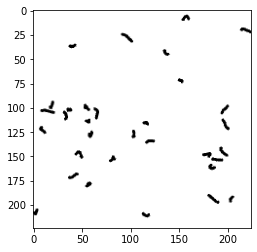

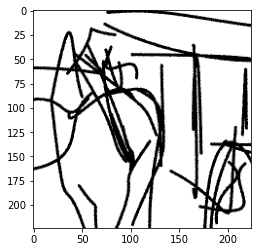

In [9]:
seed = 0
random.seed(seed)
np.random.seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)

inds_normalised = set_inds_clip(target_preprocess, attn, softmax_temp=0.3, num_stages=1, num_paths=32, canvas_width=224, canvas_height=224)
points_all = []
num_segments=1
control_points_per_seg=4
for i in range(32):
    points = []
    p0 = inds_normalised[i]
    points.append(p0)
    for j in range(num_segments):
        radius = 0.05
        for k in range(control_points_per_seg - 1):
            p1 = (p0[0] + radius * (random.random() - 0.5), p0[1] + radius * (random.random() - 0.5))
            points.append(p1)
            p0 = p1
    points = torch.tensor(points).to(device)
    points[:, 0] *= 224
    points[:, 1] *= 224

    points_all.append(points)
# path_svg = "/home/vinker/dev/background_project/experiements/mlp_12_06/mask0_semi-complex_ViT_l4_32s/mask0_semi-complex_ViT_l4_32s_seed0/svg_logs/svg_iter0.svg"
# points_all = get_initial_points(path_svg, target_, device)

points_vars = torch.stack(points_all).unsqueeze(0).to(device)
points_vars = (points_vars - points_vars.min()) / (points_vars.max() - points_vars.min())
points_vars = 2*points_vars-1

img = render_points(points_vars, 224, 32, 4, canvas_width=224, canvas_height=224)
plt.imshow(img.cpu())
plt.show()


save_path = "/home/vinker/dev/background_project/experiements/mlp_12_06/mask0_semi-complex_ViT_l4_32s/mask0_semi-complex_ViT_l4_32s_seed0/mlp.pth"

device = torch.device("cuda" if (
        torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")
canvas_size=224
num_strokes=32
num_cp=4
mlp = MLP(num_strokes=num_strokes, num_cp=num_cp).to(device)
mlp.load_state_dict(torch.load(save_path))
mlp.eval()

with torch.no_grad():
    points = mlp(points_vars)
img = render_points(points, 224, 32, 4, canvas_width=224, canvas_height=224)
plt.imshow(img.cpu())
plt.show()
# mlp = MLP(num_strokes=num_strokes, num_cp=num_cp).to(device)

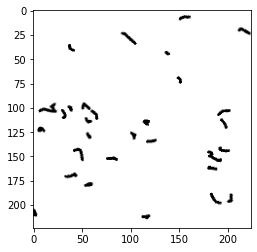

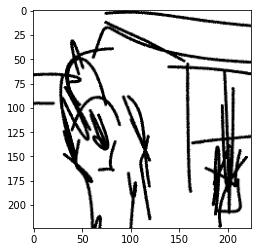

In [38]:
path_svg = "/home/vinker/dev/background_project/experiements/mlp_12_06/mask0_semi-complex_ViT_l4_32s/mask0_semi-complex_ViT_l4_32s_seed0/svg_logs/svg_iter0.svg"
points_all = get_initial_points(path_svg, target_, device)

points_vars = torch.stack(points_all).unsqueeze(0).to(device)
points_vars = (points_vars - points_vars.min()) / (points_vars.max() - points_vars.min())
points_vars = 2*points_vars-1

save_path = "/home/vinker/dev/background_project/experiements/mlp_12_06/mask0_semi-complex_ViT_l4_32s/mask0_semi-complex_ViT_l4_32s_seed0/mlp.pth"

device = torch.device("cuda" if (
        torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")
canvas_size=224
num_strokes=32
num_cp=4
mlp = MLP(num_strokes=num_strokes, num_cp=num_cp).to(device)
mlp.load_state_dict(torch.load(save_path))
mlp.eval()

with torch.no_grad():
    points = mlp(points_vars)
img = render_points(points, 224, 32, 4, canvas_width=224, canvas_height=224)
plt.imshow(img.cpu())
plt.show()
# mlp = MLP(num_strokes=num_strokes, num_cp=num_cp).to(device)

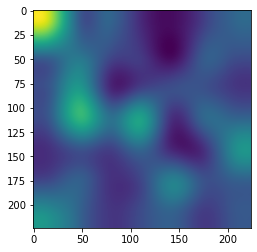

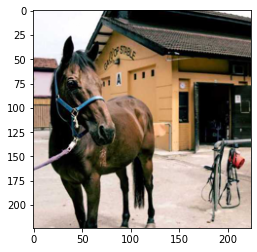

In [25]:
plt.imshow(attn)
plt.show()
plt.imshow(target[0].permute(1,2,0).cpu().numpy())
plt.show()

In [ ]:
def render_points(points, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224):
    all_points = 0.5 * (points + 1.0) * canvas_size
    eps = 1e-4
    all_points = all_points + eps*torch.randn_like(all_points)
    all_points = all_points.reshape((-1, num_strokes, num_cp, 2))
    num_control_points = torch.zeros(1, dtype = torch.int32) + (4 - 2)

    shapes = []
    shape_groups = []
    for p in range(num_strokes):
        path = pydiffvg.Path(
            num_control_points=num_control_points, points=all_points[:,p].reshape((-1,2)),
            stroke_width=torch.tensor(1.5), is_closed=False)
        shapes.append(path)
        path_group = pydiffvg.ShapeGroup(
            shape_ids=torch.tensor([len(shapes) - 1]),
            fill_color=None,
            stroke_color=torch.tensor([0,0,0,1]))
        shape_groups.append(path_group)

    # Rasterize
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
        
    # plt.imshow(img.detach().cpu().numpy())
    # plt.show()
    return img

(500, 500, 3)
(500, 500) (500, 500)
tensor(0., device='cuda:0') tensor(1., device='cuda:0')


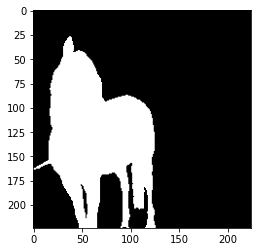

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


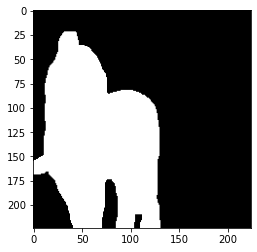

(tensor([[[[0.9804, 0.9804, 0.9804,  ..., 0.9961, 0.9961, 0.9961],
           [0.9804, 0.9804, 0.9804,  ..., 0.9961, 0.9961, 0.9961],
           [0.9804, 0.9804, 0.9804,  ..., 0.9961, 0.9961, 0.9961],
           ...,
           [0.8549, 0.8588, 0.8627,  ..., 0.8941, 0.9137, 0.9255],
           [0.8588, 0.8510, 0.8627,  ..., 0.8431, 0.8745, 0.8784],
           [0.8627, 0.8471, 0.8588,  ..., 0.9098, 0.8824, 0.8588]],
 
          [[0.9765, 0.9765, 0.9765,  ..., 0.9922, 0.9961, 0.9961],
           [0.9765, 0.9765, 0.9765,  ..., 0.9922, 0.9961, 0.9961],
           [0.9765, 0.9765, 0.9765,  ..., 0.9922, 0.9961, 0.9961],
           ...,
           [0.7882, 0.7922, 0.7961,  ..., 0.8157, 0.8353, 0.8471],
           [0.7922, 0.7843, 0.7961,  ..., 0.7647, 0.7961, 0.8000],
           [0.7961, 0.7804, 0.7922,  ..., 0.8314, 0.8039, 0.7804]],
 
          [[0.9961, 0.9961, 0.9961,  ..., 1.0000, 0.9961, 0.9961],
           [0.9961, 0.9961, 0.9961,  ..., 1.0000, 0.9961, 0.9961],
           [0.9961, 0.99

In [21]:
import torch.nn.functional as F
from skimage.transform import resize


def get_mask_u2net(pil_im, device):
    # return : numpy binary mask, with 1 where the salient object is and 0 in the background
    # assume that input image is squre
    w, h = pil_im.size[0], pil_im.size[1]
    im_size = min(w, h)
    data_transforms = transforms.Compose([
        transforms.Resize(min(320, im_size), interpolation=PIL.Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(
            0.26862954, 0.26130258, 0.27577711)),
    ])

    input_im_trans = data_transforms(pil_im).unsqueeze(0).to(device)

    model_dir = os.path.join("/home/vinker/dev/backgroundCLIPasso/CLIPasso/U2Net_/saved_models/u2net.pth")
    net = U2NET(3, 1)
    if torch.cuda.is_available():# and args.use_gpu:
        net.load_state_dict(torch.load(model_dir))
        net.to(device)
        # net.to(args.device)
    else:
        net.load_state_dict(torch.load(model_dir, map_location='cpu'))
    net.eval()
    with torch.no_grad():
        d1, d2, d3, d4, d5, d6, d7 = net(input_im_trans.detach())
    pred = d1[:, 0, :, :]
    pred = (pred - pred.min()) / (pred.max() - pred.min())
    predict = pred
    
    predict[predict < 0.5] = 0
    predict[predict >= 0.5] = 1

    # opposite mask (mask the object insteadof background)
    # predict_dilated_back = 1 - torch.tensor(ndimage.binary_dilation(predict[0].cpu().numpy(), structure=np.ones((11,11))).astype(np.int)).unsqueeze(0)
    
    mask = torch.cat([predict, predict, predict], axis=0).permute(1, 2, 0)
    mask = mask.cpu().numpy()
    mask = resize(mask, (h, w), anti_aliasing=False)
    mask[mask < 0.5] = 0
    mask[mask >= 0.5] = 1
    
    im = Image.fromarray((mask[:, :, 0]*255).astype(np.uint8)).convert('RGB')
    im_np = np.array(pil_im)
    im_np = im_np / im_np.max()
    im_np = mask * im_np
    im_np[mask == 0] = 1
    im_final = (im_np / im_np.max() * 255).astype(np.uint8)
    im_final = Image.fromarray(im_final)
    
    return im_final, mask


def get_target(target_, image_scale=224):
    target = Image.open(target_)
    if target.mode == "RGBA":
        # Create a white rgba background
        new_image = Image.new("RGBA", target.size, "WHITE")
        # Paste the image on the background.
        new_image.paste(target, (0, 0), target)
        target = new_image
    target = target.convert("RGB")

    masked_im, mask = get_mask_u2net(target, device)
    
    # if args.mask_object:
    #     target = masked_im
    # if args.fix_scale:
    #     target = fix_image_scale(target)

    transforms_ = []
    transforms_.append(transforms.Resize(
        image_scale, interpolation=PIL.Image.BICUBIC))
    transforms_.append(transforms.CenterCrop(image_scale))
    transforms_.append(transforms.ToTensor())
    data_transforms = transforms.Compose(transforms_)

    target_ = data_transforms(target).unsqueeze(0).to(device)
    print(mask.shape)
    mask = Image.fromarray((mask*255).astype(np.uint8)).convert('RGB')
    print(target.size,mask.size)
    mask = data_transforms(mask).unsqueeze(0).to(device)
    print(mask.min(), mask.max())
    mask[mask < 0.5] = 0
    mask[mask >= 0.5] = 1
    
    plt.imshow(mask.cpu()[0].permute(1,2,0))
    plt.show()
    # im_tensor = torch.Tensor(np.expand_dims(np.expand_dims(im, 0), 0)) # size:(1, 1, 5, 5)
    kernel = np.array([ [1, 1, 1],
                        [1, 1, 1],
                        [1, 1, 1] ], dtype=np.float32)
    # kernel = np.ones((3,3)).to(device)
    print(mask.shape)
    kernel_tensor = torch.ones((1,1,11,11)).to(device)
    # kernel_tensor = torch.Tensor(np.expand_dims(np.expand_dims(kernel, 0), 0)) # size: (1, 1, 3, 3)
    torch_result = torch.clamp(torch.nn.functional.conv2d(mask[:,0,:,:].unsqueeze(1), kernel_tensor, padding=(5, 5)), 0, 1)
    torch_result = torch.cat([torch_result, torch_result, torch_result], axis=1)
    print(torch_result.shape)
    plt.imshow(torch_result.cpu()[0].permute(1,2,0))
    plt.show()
    return target_, mask

get_target("/home/vinker/dev/backgroundCLIPasso/CLIPasso/target_images/semi-complex.jpeg")

In [ ]:
target = Image.open("/home/vinker/dev/backgroundCLIPasso/CLIPasso/target_images/complex-scene.png")
# (h,w) If size is an int, smaller edge of the image will be matched to this number. i.e, 
# if height > width, then image will be rescaled to (size * height / width, size).
transforms_data = transforms.Compose([transforms.Resize(
        image_scale, interpolation=PIL.Image.BICUBIC)])